Calculating AUC just for single task ID.<br> Therefore, not making a scalable solution for POC.

In [166]:
import json
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
import pprint as pp
import math
import random
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [167]:
filepath = "../data/student_vectors_n_task_10_n_limit_10000.json"
student_vectors = json.load(open(filepath))

In [168]:
task_ids = []
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in task_ids:
            task_ids.append(j['task_id'])
print("Number of unique task IDs: " + str(len(task_ids)))
print("Number of students: " + str(len(student_vectors)))

Number of unique task IDs: 10
Number of students: 1255


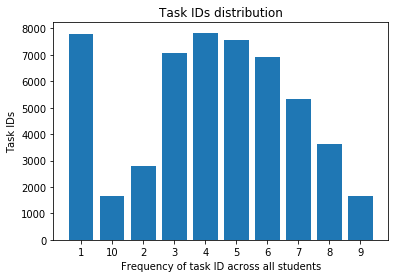

Task IDs mapping: 
Task ID -> p7cfRPp-kQ.partb(1) is attempted 7776 times.
Task ID -> Ok-iIHxjgx.partb(2) is attempted 2789 times.
Task ID -> 1zsCldT4p8.set1(3) is attempted 7061 times.
Task ID -> DebcfZEEmI.proper_fractions(4) is attempted 7836 times.
Task ID -> 9wRCzK1G7F.partb(5) is attempted 7552 times.
Task ID -> 1zsCldT4p8.set2(6) is attempted 6905 times.
Task ID -> nl-M69Ez9k.parta(7) is attempted 5335 times.
Task ID -> kvig7fcCVc.partb(8) is attempted 3621 times.
Task ID -> Ok-iIHxjgx.parta(9) is attempted 1670 times.
Task ID -> hyei4uD81i.parta(10) is attempted 1664 times.


In [177]:
#frequency distribution of taskids
cnt2 = Counter()
another_2 = {}
position_2 = 1
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in another_2:
            another_2[j['task_id']] = str(position_2)
            position_2 = position_2 + 1
        cnt2[another_2[j['task_id']]] += 1
plt.bar(cnt2.keys(), cnt2.values())
plt.title("Task IDs distribution")
plt.xlabel("Frequency of task ID across all students")
plt.ylabel("Task IDs")
plt.show()
print("Task IDs mapping: ")
for i in another_2:
    print("Task ID -> "+str(i)+"("+str(another_2[i])+") is attempted " + str(cnt2[another_2[i]]) + " times.")

In [182]:
test_AUC_all_tasks = {}
train_AUC_all_tasks = {}
tasks_best_run = {}
for i in another_2:
    print("\n\n\nCalculating for Task ID: "+str(i)+" which has the frequency: " + str(cnt2[another_2[i]]) + "\n")
    train_AUC_taski = []
    test_AUC_taski = []
    #make sequences
    sequences = []
    sequences_lengths = []
    for p in student_vectors:
        interactions = []
        for j in student_vectors[p]:
            if(j['task_id'] == i and j['second_try'] == False):
                if(j['correct'] == True):
                    interactions.append([1.,0.])
                else:
                    interactions.append([0.,1.])
        if(len(interactions) > 1):
            sequences_lengths.append(len(interactions))
            sequences.append(interactions)

    #do the padding
    padded_sequences = np.zeros([len(sequences),max(sequences_lengths),2])
    for p in range(len(sequences)):
        for j in range(len(sequences[p])):
            padded_sequences[p][j] = sequences[p][j]

    #split the train and test set like BKT
    split = int(0.8*len(sequences))
    train_x = padded_sequences[:split,:-1]
    train_y = padded_sequences[:split,1:]
    train_seqlen = sequences_lengths[:split]
    test_x = padded_sequences[split:,:-1]
    test_y = padded_sequences[split:,1:]
    test_seqlen = sequences_lengths[split:]

    num_units = 64
    len_vector = 2
    l_rate = 0.01
    epochs = 40
    display_ep = 5
    
    for r in range(5): #repeat only 5 times
        print("\n\n"+ str(r+1) + " Time Run.")
        # build the network
        tf.reset_default_graph()
        #placeholders
        x = tf.placeholder(tf.float32, [None, max(sequences_lengths)-1, len_vector])
        y = tf.placeholder(tf.float32, [None, max(sequences_lengths)-1, len_vector])
        seqlen_tf = tf.placeholder(tf.float32,[None])

        #dynamic RNN definition
        def dynamicRNN(x):
            rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
            outputs, states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32,sequence_length=seqlen_tf)
            out_size = len_vector
            logit = tf.contrib.layers.fully_connected(outputs, out_size)
            outputs = tf.nn.sigmoid(logit)
            return outputs

        pred = dynamicRNN(x)
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y))
        #optimizer = tf.train.AdamOptimizer(learning_rate=l_rate).minimize(cost)
        optimizer = tf.train.MomentumOptimizer(learning_rate=l_rate,momentum=0.9).minimize(cost)
        auc,  opts = tf.metrics.auc(labels = y, predictions = pred, curve='ROC')

        #execute the network
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            for epoch in range(1, epochs+1):
                sess.run(optimizer, feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen})
                if epoch % display_ep == 0 or epoch == 1:
                    loss, trainAUC, trainOPTS = sess.run([cost,auc,opts], feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen})
                    testAUC, testOPTS = sess.run([auc,opts], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen})
                    print("Step: " + str(epoch) +", cost: "+str(loss)+ ", train set AUC: " + str(trainOPTS) + ", test set AUC: "+ str(testOPTS) +";")
            prediction = sess.run([pred], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen})
            view_point = np.argmax(test_seqlen)
            print("\n\ntrue:\n")
            print(test_x[view_point][:test_seqlen[view_point]])
            print("\n\nprediction\n")
            print(prediction[0][view_point][:test_seqlen[view_point]])
            train_AUC_taski.append(trainOPTS)
            test_AUC_taski.append(testOPTS)
    test_AUC_all_tasks[i] = np.max(test_AUC_taski)
    train_AUC_all_tasks[i] = np.max(train_AUC_taski[np.argmax(test_AUC_taski)])
    tasks_best_run[i] = np.argmax(test_AUC_taski)+1




Calculating for Task ID: p7cfRPp-kQ.partb which has the frequency: 7776



1 Time Run.
Step: 1, cost: 0.9460295, train set AUC: 0.8593059, test set AUC: 0.8589169;
Step: 5, cost: 0.94603413, train set AUC: 0.8590227, test set AUC: 0.858839;
Step: 10, cost: 0.94603485, train set AUC: 0.8589465, test set AUC: 0.85883236;
Step: 15, cost: 0.94603413, train set AUC: 0.8589124, test set AUC: 0.8588283;
Step: 20, cost: 0.94603163, train set AUC: 0.8589082, test set AUC: 0.8588447;
Step: 25, cost: 0.9460285, train set AUC: 0.85891956, test set AUC: 0.8588673;
Step: 30, cost: 0.946028, train set AUC: 0.85893905, test set AUC: 0.8588953;
Step: 35, cost: 0.94602597, train set AUC: 0.8589629, test set AUC: 0.85892683;
Step: 40, cost: 0.9460189, train set AUC: 0.8590601, test set AUC: 0.85904473;


true:

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0.

Step: 1, cost: 0.91773725, train set AUC: 0.8997155, test set AUC: 0.9012423;
Step: 5, cost: 0.9177099, train set AUC: 0.9004761, test set AUC: 0.9012032;
Step: 10, cost: 0.91764885, train set AUC: 0.90032333, test set AUC: 0.900721;
Step: 15, cost: 0.91757685, train set AUC: 0.8998262, test set AUC: 0.9002512;
Step: 20, cost: 0.9175063, train set AUC: 0.8996039, test set AUC: 0.8998339;
Step: 25, cost: 0.91744363, train set AUC: 0.899104, test set AUC: 0.899195;
Step: 30, cost: 0.9173906, train set AUC: 0.89411837, test set AUC: 0.893633;
Step: 35, cost: 0.9173489, train set AUC: 0.8896528, test set AUC: 0.8893153;
Step: 40, cost: 0.9173149, train set AUC: 0.8859483, test set AUC: 0.8856868;


true:

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


prediction

[[0.5038337  0.5104526 ]
 [0.50684315 0.5221051 ]
 [0.5087357  0.5309702 ]
 [0.510074

Step: 1, cost: 0.94145566, train set AUC: 0.5176247, test set AUC: 0.51887786;
Step: 5, cost: 0.94142604, train set AUC: 0.51776016, test set AUC: 0.5179241;
Step: 10, cost: 0.9413567, train set AUC: 0.51421064, test set AUC: 0.5139393;
Step: 15, cost: 0.9412722, train set AUC: 0.5108629, test set AUC: 0.5104905;
Step: 20, cost: 0.94119513, train set AUC: 0.5088617, test set AUC: 0.50840986;
Step: 25, cost: 0.9411581, train set AUC: 0.50731343, test set AUC: 0.50703245;
Step: 30, cost: 0.94115657, train set AUC: 0.50624895, test set AUC: 0.50604266;
Step: 35, cost: 0.94115657, train set AUC: 0.50545484, test set AUC: 0.50529706;
Step: 40, cost: 0.94115657, train set AUC: 0.50483984, test set AUC: 0.50471526;


true:

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0

Step: 1, cost: 0.94076353, train set AUC: 0.9271334, test set AUC: 0.9286419;
Step: 5, cost: 0.9407332, train set AUC: 0.9277707, test set AUC: 0.9283631;
Step: 10, cost: 0.94067097, train set AUC: 0.9235154, test set AUC: 0.9231563;
Step: 15, cost: 0.94058615, train set AUC: 0.92057383, test set AUC: 0.9201811;
Step: 20, cost: 0.9404935, train set AUC: 0.9185251, test set AUC: 0.91804564;
Step: 25, cost: 0.94041157, train set AUC: 0.9161563, test set AUC: 0.91557354;
Step: 30, cost: 0.9403655, train set AUC: 0.9126394, test set AUC: 0.9117735;
Step: 35, cost: 0.9403543, train set AUC: 0.9085426, test set AUC: 0.90770423;
Step: 40, cost: 0.94035006, train set AUC: 0.90509474, test set AUC: 0.90440357;


true:

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


prediction

[[0.5004129  0.5       ]
 [0.5020131  0.

Step: 20, cost: 0.9459862, train set AUC: 0.93755615, test set AUC: 0.93771327;
Step: 25, cost: 0.945912, train set AUC: 0.93616796, test set AUC: 0.93607646;
Step: 30, cost: 0.94584316, train set AUC: 0.9347447, test set AUC: 0.9346537;
Step: 35, cost: 0.9457819, train set AUC: 0.9333507, test set AUC: 0.9332521;
Step: 40, cost: 0.9457264, train set AUC: 0.93107134, test set AUC: 0.93078566;


true:

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


prediction

[[0.5065729  0.5       ]
 [0.5131883  0.5017405 ]
 [0.51878685 0.50627536]
 [0.5234117  0.5106994 ]
 [0.5271626  0.5147715 ]
 [0.5301618  0.51835924]
 [0.53253347 0.5214055 ]
 [0.53439254 0.5239041 ]
 [0.5444204  0.51979685]
 [0.55126786 0.51392674]
 [0.55624723 0.50663584]
 [0.55993927 0.5       ]
 [0.5627293  0.5       ]
 [0.5648682  0.5       ]
 [0.5665222  0.5       ]
 [0.567

Step: 1, cost: 0.93466187, train set AUC: 0.57659376, test set AUC: 0.58216107;
Step: 5, cost: 0.93465984, train set AUC: 0.57641536, test set AUC: 0.578627;
Step: 10, cost: 0.9346544, train set AUC: 0.5743082, test set AUC: 0.5756213;
Step: 15, cost: 0.934649, train set AUC: 0.5725173, test set AUC: 0.5733518;
Step: 20, cost: 0.93464375, train set AUC: 0.5710638, test set AUC: 0.5717015;
Step: 25, cost: 0.93463844, train set AUC: 0.56995964, test set AUC: 0.5704943;
Step: 30, cost: 0.9346347, train set AUC: 0.5691487, test set AUC: 0.56961316;
Step: 35, cost: 0.9346307, train set AUC: 0.5684849, test set AUC: 0.56891596;
Step: 40, cost: 0.9346282, train set AUC: 0.56795627, test set AUC: 0.5683274;


true:

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


prediction

[[0.50252235 0.50633484]

Step: 1, cost: 0.94653255, train set AUC: 0.5582045, test set AUC: 0.555031;
Step: 5, cost: 0.9465354, train set AUC: 0.55308336, test set AUC: 0.5511777;
Step: 10, cost: 0.94653577, train set AUC: 0.54952824, test set AUC: 0.54823416;
Step: 15, cost: 0.9465353, train set AUC: 0.5472693, test set AUC: 0.5463754;
Step: 20, cost: 0.94653493, train set AUC: 0.54596317, test set AUC: 0.54527134;
Step: 25, cost: 0.9465345, train set AUC: 0.5449418, test set AUC: 0.5443977;
Step: 30, cost: 0.946534, train set AUC: 0.54356074, test set AUC: 0.54305965;
Step: 35, cost: 0.94653356, train set AUC: 0.5425834, test set AUC: 0.5421988;
Step: 40, cost: 0.9465333, train set AUC: 0.54205084, test set AUC: 0.5417622;


true:

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


prediction

[[0.5

Step: 1, cost: 0.9182991, train set AUC: 0.5, test set AUC: 0.5;
Step: 5, cost: 0.9182992, train set AUC: 0.5, test set AUC: 0.5;
Step: 10, cost: 0.9182992, train set AUC: 0.5, test set AUC: 0.5;
Step: 15, cost: 0.91829926, train set AUC: 0.5, test set AUC: 0.5;
Step: 20, cost: 0.91829926, train set AUC: 0.5, test set AUC: 0.5;
Step: 25, cost: 0.91829926, train set AUC: 0.5, test set AUC: 0.5;
Step: 30, cost: 0.91829926, train set AUC: 0.5, test set AUC: 0.5;
Step: 35, cost: 0.91829926, train set AUC: 0.5, test set AUC: 0.5;
Step: 40, cost: 0.91829926, train set AUC: 0.5, test set AUC: 0.5;


true:

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


prediction

[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]


Step: 1, cost: 0.9202855, train set AUC: 0.5103577, test set AUC: 0.51054573;
Step: 5, cost: 0.9202855, train set AUC: 0.5104629, test set AUC: 0.51054573;
Step: 10, cost: 0.92028564, train set AUC: 0.5104926, test set AUC: 0.51054573;
Step: 15, cost: 0.92028564, train set AUC: 0.51050663, test set AUC: 0.51054573;
Step: 20, cost: 0.92028564, train set AUC: 0.5105148, test set AUC: 0.51054573;
Step: 25, cost: 0.92028564, train set AUC: 0.51052016, test set AUC: 0.51054573;
Step: 30, cost: 0.9202855, train set AUC: 0.5105239, test set AUC: 0.51054573;
Step: 35, cost: 0.9202855, train set AUC: 0.5105267, test set AUC: 0.51054573;
Step: 40, cost: 0.92028564, train set AUC: 0.5105289, test set AUC: 0.51054573;


true:

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 

Step: 40, cost: 0.89963627, train set AUC: 0.50968456, test set AUC: 0.5097999;


true:

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


prediction

[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.

In [184]:
pp.pprint(test_AUC_all_tasks)
pp.pprint(train_AUC_all_tasks)
pp.pprint(tasks_best_run)

{'1zsCldT4p8.set1': 0.8794418,
 '1zsCldT4p8.set2': 0.9398666,
 '9wRCzK1G7F.partb': 0.93078566,
 'DebcfZEEmI.proper_fractions': 0.90807587,
 'Ok-iIHxjgx.parta': 0.9582003,
 'Ok-iIHxjgx.partb': 0.8856868,
 'hyei4uD81i.parta': 0.75419533,
 'kvig7fcCVc.partb': 0.96008945,
 'nl-M69Ez9k.parta': 0.9598291,
 'p7cfRPp-kQ.partb': 0.9395003}
{'1zsCldT4p8.set1': 0.8796457,
 '1zsCldT4p8.set2': 0.9405429,
 '9wRCzK1G7F.partb': 0.93107134,
 'DebcfZEEmI.proper_fractions': 0.9087461,
 'Ok-iIHxjgx.parta': 0.9582019,
 'Ok-iIHxjgx.partb': 0.8859483,
 'hyei4uD81i.parta': 0.75387836,
 'kvig7fcCVc.partb': 0.9601055,
 'nl-M69Ez9k.parta': 0.95951253,
 'p7cfRPp-kQ.partb': 0.93952227}
{'1zsCldT4p8.set1': 3,
 '1zsCldT4p8.set2': 1,
 '9wRCzK1G7F.partb': 1,
 'DebcfZEEmI.proper_fractions': 4,
 'Ok-iIHxjgx.parta': 3,
 'Ok-iIHxjgx.partb': 0,
 'hyei4uD81i.parta': 0,
 'kvig7fcCVc.partb': 1,
 'nl-M69Ez9k.parta': 1,
 'p7cfRPp-kQ.partb': 4}


In [186]:
for i in another_2:
    print(str(train_AUC_all_tasks[i]) + "\t" + str(test_AUC_all_tasks[i]) + "\t" + str(tasks_best_run[i]))
    print(i)

0.93952227	0.9395003	4
p7cfRPp-kQ.partb
0.8859483	0.8856868	0
Ok-iIHxjgx.partb
0.8796457	0.8794418	3
1zsCldT4p8.set1
0.9087461	0.90807587	4
DebcfZEEmI.proper_fractions
0.93107134	0.93078566	1
9wRCzK1G7F.partb
0.9405429	0.9398666	1
1zsCldT4p8.set2
0.95951253	0.9598291	1
nl-M69Ez9k.parta
0.9601055	0.96008945	1
kvig7fcCVc.partb
0.9582019	0.9582003	3
Ok-iIHxjgx.parta
0.75387836	0.75419533	0
hyei4uD81i.parta
